In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime



In [ ]:
# Subir archivo directamente
uploaded = files.upload()

Saving [HackMTY2025]_AlcoholBottleHandling_Dataset_v1.xlsx to [HackMTY2025]_AlcoholBottleHandling_Dataset_v1 (1).xlsx
Saving [HackMTY2025]_ConsumptionPrediction_Dataset_v1.xlsx to [HackMTY2025]_ConsumptionPrediction_Dataset_v1 (1).xlsx
Saving [HackMTY2025]_EmployeeEfficiency_Dataset_v1.xlsx to [HackMTY2025]_EmployeeEfficiency_Dataset_v1 (1).xlsx
Saving [HackMTY2025]_ExpirationDateManagement_Dataset_v1.xlsx to [HackMTY2025]_ExpirationDateManagement_Dataset_v1 (1).xlsx
Saving [HackMTY2025]_ProductivityEstimation_Dataset_v1.xlsx to [HackMTY2025]_ProductivityEstimation_Dataset_v1 (1).xlsx
Saving [HackMTY2025]_RealTimeErrorDetection_Dataset_v1.xlsx to [HackMTY2025]_RealTimeErrorDetection_Dataset_v1 (1).xlsx
Saving Hackatlon Consumption and Estimation - Gategroup Dataset 1 de 2.xlsx to Hackatlon Consumption and Estimation - Gategroup Dataset 1 de 2 (1).xlsx
Saving result_hack 3.2 REDUCED A.xlsx to result_hack 3.2 REDUCED A (1).xlsx
Saving result_hack 3.2 REDUCED b.xlsx to result_hack 3.2 RED

In [ ]:
# Upload + installs (Colab)
!pip install -q xgboost tensorflow

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Cargar datos (sube el archivo al entorno de Colab si es necesario)
PATH = '[HackMTY2025]_ConsumptionPrediction_Dataset_v1.xlsx'
df = pd.read_excel(PATH)

# 2. Básico cleaning y tipos
df = df.copy()
# columnas esperadas: Date, Flight_ID, Product_ID, Product_Name, Passenger_Count, Standard_Specification_Qty, Unit_Cost, Quantity_Consumed, Quantity_Returned
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Quantity_Consumed'].notna()]
df['Crew_Feedback'] = df.get('Crew_Feedback').fillna('no_feedback')

# 3. Feature engineering mínima y efectiva
df['day_of_week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
df['pass_per_spec'] = df['Passenger_Count'] / (df['Standard_Specification_Qty'].replace(0, np.nan))
df['return_ratio'] = df['Quantity_Returned'] / (df['Quantity_Consumed'] + 1e-6)

# lag and rolling features per product (critical for consumption patterns)
df = df.sort_values(['Product_ID','Date'])
for lag in [1,2,3,7]:
    df[f'lag_{lag}'] = df.groupby('Product_ID')['Quantity_Consumed'].shift(lag)
for w in [3,7,14]:
    df[f'roll_mean_{w}'] = df.groupby('Product_ID')['Quantity_Consumed'].transform(lambda x: x.rolling(w, min_periods=1).mean())
    df[f'roll_std_{w}'] = df.groupby('Product_ID')['Quantity_Consumed'].transform(lambda x: x.rolling(w, min_periods=1).std().fillna(0))

# fill na from lag/rolling with sensible values
df.fillna({
    'lag_1': 0, 'lag_2': 0, 'lag_3': 0, 'lag_7': 0,
    'roll_mean_3': 0, 'roll_mean_7': 0, 'roll_mean_14': 0,
    'roll_std_3': 0, 'roll_std_7': 0, 'roll_std_14': 0,
    'pass_per_spec': 0, 'return_ratio': 0
}, inplace=True)

# 4. Categorical encoding minimal (frequency)
for col in ['Flight_Type','Service_Type','Origin','Product_ID']:
    if col in df.columns:
        freq = df[col].value_counts().to_dict()
        df[f'{col}_freq'] = df[col].map(freq)

# 5. Feature list
exclude = ['Date','Flight_ID','Product_Name','Quantity_Consumed','Quantity_Returned','Crew_Feedback']
features = [c for c in df.columns if c not in exclude and df[c].dtype in [np.float64, np.int64]]
X = df[features].fillna(0)
y = df['Quantity_Consumed']

# 6. Stratified split by consumption ranges for stable evaluation
bins = [0,70,120,250, np.inf]
labels = [0,1,2,3]
strata = pd.cut(y, bins=bins, labels=labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=strata, random_state=42)

# 7. Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# 8. XGBoost baseline model with early stopping via CV
dtrain = xgb.DMatrix(X_train_s, label=y_train)
params = {
    'objective':'reg:squarederror',
    'learning_rate':0.05,
    'max_depth':6,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'random_state':42,
    'nthread':4
}
cv_results = xgb.cv(params, dtrain, num_boost_round=500, nfold=5, early_stopping_rounds=30, metrics='mae', as_pandas=True, seed=42, verbose_eval=False)
best_n = int(cv_results.shape[0])
xgb_model = xgb.train(params, dtrain, num_boost_round=best_n)

# 9. Simple neural net on same features (small, regularized)
def build_nn(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

nn = build_nn(X_train_s.shape[1])
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)
history = nn.fit(X_train_s, y_train, validation_split=0.15, epochs=200, batch_size=32, callbacks=[es], verbose=0)

# 10. Ensemble: average predictions (XGB + NN)
xgb_pred_test = xgb_model.predict(xgb.DMatrix(X_test_s))
nn_pred_test = nn.predict(X_test_s).flatten()
ensemble_pred_test = 0.5 * xgb_pred_test + 0.5 * nn_pred_test

# 11. Metrics and percent error
mae = mean_absolute_error(y_test, ensemble_pred_test)
r2 = r2_score(y_test, ensemble_pred_test)
mean_consumption = y_test.mean()
error_pct = 100.0 * (mae / (mean_consumption + 1e-9))

print(f"MAE ensemble: {mae:.4f}")
print(f"R2 ensemble: {r2:.4f}")
print(f"Error porcentual respecto al consumo medio: {error_pct:.2f}%")

# 12. If error_pct > 2% quick suggestions executed programmatically
if error_pct > 2.0:
    # simple targeted actions to reduce error without heavy hyperopt:
    # a) retrain XGBoost with best_n*1.5 and slight lr reduction
    params['learning_rate'] = 0.03
    xgb_model2 = xgb.train(params, dtrain, num_boost_round=int(best_n*1.5))
    xgb_pred2 = xgb_model2.predict(xgb.DMatrix(X_test_s))
    ensemble2 = 0.6 * xgb_pred2 + 0.4 * nn_pred_test
    mae2 = mean_absolute_error(y_test, ensemble2)
    error_pct2 = 100.0 * (mae2 / (mean_consumption + 1e-9))
    print(f"After quick XGB retrain MAE: {mae2:.4f}, Error%: {error_pct2:.2f}%")
    # keep the better ensemble
    if mae2 < mae:
        ensemble_pred_test = ensemble2
        mae, error_pct = mae2, error_pct2

# 13. Save models (optional)
import joblib
xgb_model.save_model('xgb_model.json')
nn.save('nn_model.h5')
joblib.dump(scaler, 'scaler.pkl')

# Final check
print(f"FINAL MAE: {mae:.4f}, FINAL ERROR%: {error_pct:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


MAE ensemble: 1.3940
R2 ensemble: 0.9971
Error porcentual respecto al consumo medio: 1.53%
FINAL MAE: 1.3940, FINAL ERROR%: 1.53%


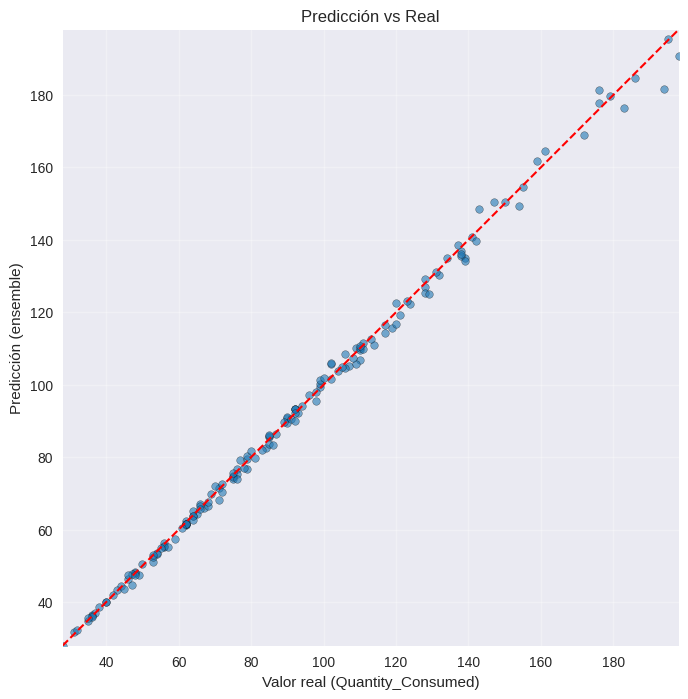

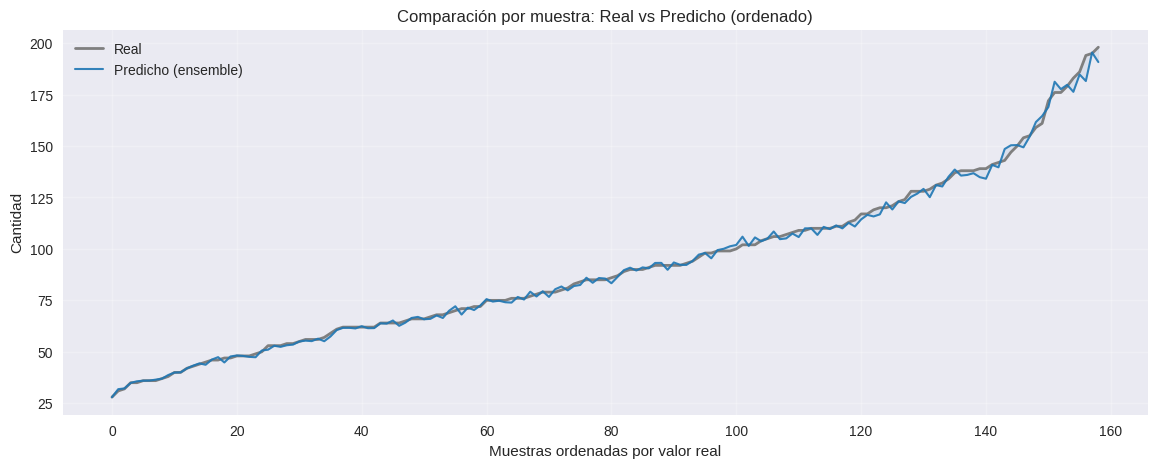

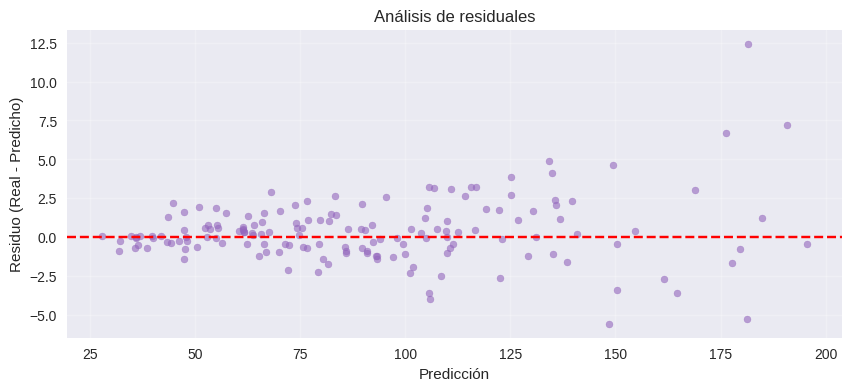

In [ ]:
# Asegúrate que y_test y ensemble_pred_test estén en el mismo orden y tipo (pandas Series o numpy arrays)
y_true = pd.Series(y_test).reset_index(drop=True)
y_pred = pd.Series(ensemble_pred_test).reset_index(drop=True)

# 1) Scatter Predicho vs Real con línea identidad
plt.figure(figsize=(8,8))
plt.scatter(y_true, y_pred, alpha=0.6, s=30, color='tab:blue', edgecolor='k')
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=1.5)            # línea identidad
plt.xlabel('Valor real (Quantity_Consumed)')
plt.ylabel('Predicción (ensemble)')
plt.title('Predicción vs Real')
plt.grid(alpha=0.3)
plt.xlim(lims)
plt.ylim(lims)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# 2) Serie ordenada por valor real (visualiza el comportamiento por muestra)
df_comp = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
df_comp = df_comp.sort_values('y_true').reset_index(drop=True)

plt.figure(figsize=(14,5))
plt.plot(df_comp['y_true'].values, label='Real', linewidth=2, color='tab:gray')
plt.plot(df_comp['y_pred'].values, label='Predicho (ensemble)', linewidth=1.5, color='tab:blue', alpha=0.9)
plt.fill_between(range(len(df_comp)), df_comp['y_true'].values, df_comp['y_pred'].values,
                 color='tab:blue', alpha=0.08)
plt.xlabel('Muestras ordenadas por valor real')
plt.ylabel('Cantidad')
plt.title('Comparación por muestra: Real vs Predicho (ordenado)')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

# 3) Residuales (opcional rápido)
residuales = y_true - y_pred
plt.figure(figsize=(10,4))
plt.scatter(y_pred, residuales, alpha=0.6, s=25, color='tab:purple')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicción')
plt.ylabel('Residuo (Real - Predicho)')
plt.title('Análisis de residuales')
plt.grid(alpha=0.25)
plt.show()
